In [2]:
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#csv-Datei importieren
csv_datei = "DennisDDDeDe.csv"
df_data = pd.read_csv(csv_datei, sep=';', decimal = ',')
df_data
# Verbrauch = elektrische Last

,Zeit,Verbrauch,PV-Ertrag,Netzeinspeisung,Thermische Last
0,01.01. 00:00,0.016247,0.0,0.0,2.0
1,01.01. 01:00,0.016162,0.0,0.0,1.9
2,01.01. 02:00,0.016005,0.0,0.0,2.0
3,01.01. 03:00,0.166450,0.0,0.0,1.9
4,01.01. 04:00,0.016200,0.0,0.0,1.9
...,...,...,...,...,...
8755,31.12. 19:00,1.107500,0.0,0.0,5.8
8756,31.12. 20:00,0.261240,0.0,0.0,6.3
8757,31.12. 21:00,0.289830,0.0,0.0,5.4
8758,31.12. 22:00,0.340810,0.0,0.0,3.4


In [4]:
#Spaltennamen vergeben 
pv_ertrag = df_data['PV-Ertrag']
elektrische_last = df_data['Verbrauch ']
thermische_last = df_data['Thermische Last ']
netzeinspeisung = df_data['Netzeinspeisung ']

In [5]:
#Annahmen für das Ref-Netzwerke

#Marginale Kosten
strompreis_bezug = 0.40
strompreis_einspeisung = -0.08               

#Kapitalkosten pro Jahr pro kW
kapital_kosten_batteriespeicher = 892/12.5          #892€/kWh auf 12.5 Jahre
kapital_kosten_pufferspeicher = 53.32/20            #Preis(1965€)/36,85kWh (800l) 
kapital_kosten_wp = 80
kapital_kosten_pv = 100                             #10kWp Anlage ink. WR für 20000€ auf 20 Jahre

#Wirkungsgrade der Komponenten
wirkungsgrad_batteriespeicher_laden = 0.88        
wirkungsgrad_batteriespeicher_entladen = 0.88       #Wirkungsgrad von wurzel(77%)
selbstentlade_verluste_bs = 0.07
selbstentlade_verluste_ps = 0.08
wirkungsgrad_wp = 3.5                               #aktuell den COP als konstant angenommen


In [6]:
# Refrenznetzwerk = Ref-Netzwerk

In [7]:
# define reference Network
ref_network = pypsa.Network()
ref_network.set_snapshots(df_data.index)

#Busses
ref_network.add('Bus', name = 'strom', carrier='AC')
ref_network.add('Bus', name = 'waerme', carrier='heat')
ref_network.add('Bus',name= 'batterie', carrier='AC')
ref_network.add('Bus', name ='ueberschuss', carrier= 'AC')

#Generatoren
ref_network.add('Generator', name = 'pv_generator', bus = 'ueberschuss',capital_cost = kapital_kosten_pv, p_nom_extendable = True, p_nom_max = 10 ,p_max_pu= pv_ertrag/10, carrier = 'AC')
ref_network.add('Generator', name = 'netzbezug' , bus= 'strom', p_nom = elektrische_last.max(), marginal_cost = strompreis_bezug, carrier = 'AC')
ref_network.add('Generator', name = 'netzeinspeisung' , bus= 'ueberschuss', p_nom_extendable = True, 
            marginal_cost = strompreis_einspeisung,sign = -1, carrier = 'AC')

#Lasten
ref_network.add('Load', name= 'thermische_last', bus='waerme',p_set = thermische_last)
ref_network.add('Load', name= 'elektrische_last', bus='strom',p_set = elektrische_last)

#Speicher
ref_network.add('Store' , name = 'batteriespeicher', bus= 'batterie', e_nom_extendable = True,
            capital_cost = kapital_kosten_batteriespeicher , standing_loss = selbstentlade_verluste_bs)
ref_network.add('Store', name= 'pufferspeicher', bus= 'waerme', e_nom_extendable = True ,capital_cost= kapital_kosten_pufferspeicher
        ,standing_loss= selbstentlade_verluste_ps)

#Links
ref_network.add('Link', name = 'Bs_entladen', bus0= 'batterie', bus1='strom',p_nom_extendable = True,
            efficiency= wirkungsgrad_batteriespeicher_entladen)
ref_network.add('Link', name = 'Bs_laden', bus0= 'strom', bus1='batterie' ,p_nom_extendable = True, 
            efficiency= wirkungsgrad_batteriespeicher_laden)
ref_network.add ('Link',name= 'eigenverbrauch', bus0= 'ueberschuss', bus1= 'strom', p_nom_extendable = True)
ref_network.add('Link', name= 'waermepumpe', bus0= 'strom', bus1='waerme',p_nom_extendable = True, p_nom_min = 12.5,
            efficiency= wirkungsgrad_wp, capital_cost= kapital_kosten_wp) #p_nom_min im Referenzmodell laut Berechnungen 12.5

In [14]:
ref_network.optimize(solver_name = 'gurobi', threads = 1, method = 1)
#ref_network.lopf(pyomo=False, solver_name='gurobi')  #Effizienter laufen soll

INFO:linopy.model: Solve linear problem using Gurobi solver
INFO:linopy.model:Solver options:
 - threads: 1
 - method: 1
Writing variables.: 100%|██████████| 7/7 [00:00<00:00, 29.60it/s]

Read LP format model from file /tmp/linopy-problem-j5gvrv0r.lp


Reading time = 0.88 seconds
obj: 210249 rows, 96368 columns, 389783 nonzeros
Set parameter Threads to value 1
Set parameter Method to value 1
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 12 physical cores, 12 logical processors, using up to 1 threads

Optimize a model with 210249 rows, 96368 columns and 389783 nonzeros
Model fingerprint: 0xe2a8618e
Coefficient statistics:
  Matrix range     [4e-06, 4e+00]
  Objective range  [8e-02, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 2e+01]
Presolve removed 153356 rows and 35135 columns
Presolve time: 0.70s
Presolved: 56893 rows, 61233 columns, 166254 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.2425499e+01   1.900011e+04   0.000000e+00      1s
   31507    3.8776822e+03   1.689339e+05   0.000000e+00      5s
   41896    4.2587141e+03   8.976411e+03   0.000000e+

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 96368 primals, 210249 duals
Objective: 4.42e+03
Solver model: available
Solver message: 2



('ok', 'optimal')

<AxesSubplot: xlabel='snapshot'>

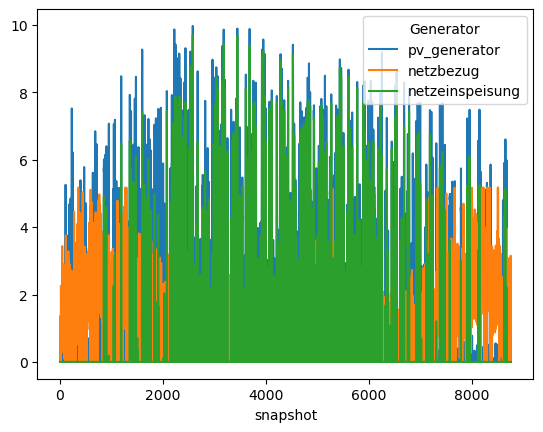

In [9]:
ref_network.generators_t.p.plot()

<AxesSubplot: xlabel='snapshot'>

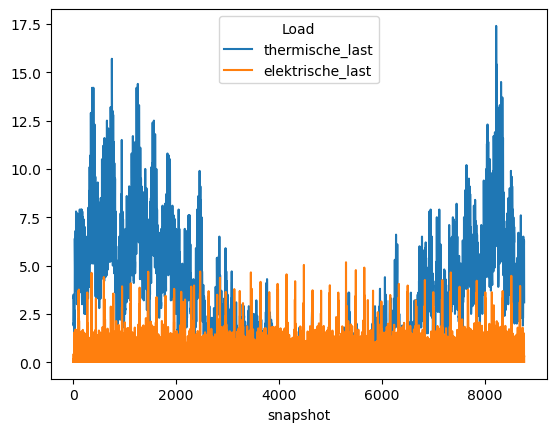

In [39]:
ref_network.loads_t.p.plot()

array([<AxesSubplot: xlabel='snapshot'>, <AxesSubplot: xlabel='snapshot'>,
       <AxesSubplot: xlabel='snapshot'>], dtype=object)

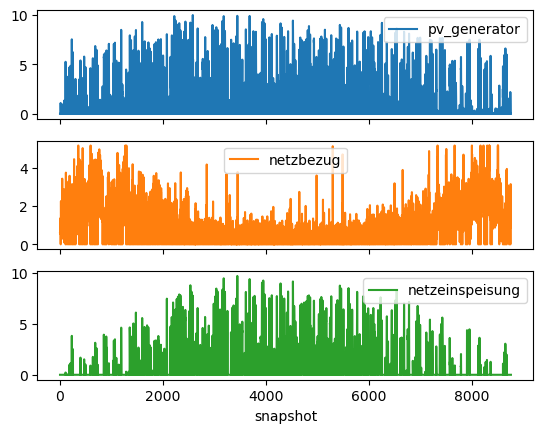

In [40]:
ref_network.generators_t.p.plot(subplots=True)

In [10]:
ref_network.generators_t.p.sum()

Generator
pv_generator       11581.694010
netzbezug           6849.024854
netzeinspeisung     5416.117381
dtype: float64

In [11]:
ref_network.loads_t.p.sum() #Bemerkung: trotz einfügens einer Wärmepumpe bzw. den Link der Wärmepumpe ist die elektrische Last nicht gestiegen

Load
thermische_last     29667.000000
elektrische_last     3304.001502
dtype: float64

In [13]:
ref_network.stores.e_nom_opt

Store
batteriespeicher     0.000000
pufferspeicher      41.015263
Name: e_nom_opt, dtype: float64